In [33]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import wandb
import pandas as pd

In [34]:
from sine_data_generator import SineDataGenerator
from models.decoder import Decoder
from models.utils import ReluNet, make_leave_one_out
from models.encoder import DeterministicIOPairSetEncoder
from models.lpn import DeterministicLPN


In [35]:
def set_seed(seed=1):
    np.random.seed(seed)                      
    torch.manual_seed(seed)                   
    torch.cuda.manual_seed(seed)              
    torch.cuda.manual_seed_all(seed)          
    
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False    

set_seed(1)

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

d_latent = 5

In [37]:

# Create encoder
encoder = DeterministicIOPairSetEncoder(
    phi=ReluNet(2, 32, 32),
    rho_0=ReluNet(32, 32, 16),
    rho_1=ReluNet(16, 8, d_latent)
)

# Create decoder
decoder = Decoder(
    d_input=1, 
    d_latent=d_latent, 
    ds_hidden=[32, 32], 
    d_output=1
)

# Create the model
lpn = DeterministicLPN(
    d_input=1,
    d_output=1,
    d_latent=d_latent,
    encoder=encoder,
    decoder=decoder
).to(device)

# Create data generator for training
n_samples_per_task = 20
batch_size = 25
data_gen = SineDataGenerator(n_samples_per_task, batch_size)
print(type(data_gen))
print(data_gen.generate()[0].shape)

<class 'sine_data_generator.SineDataGenerator'>
torch.Size([25, 20, 1])


In [38]:
# Training function
def train_deterministic_lpn(lpn, data_gen, device):
    wandb.init(project="deterministic_lpn4sine_cf_maml")
        
    n_metaiter = 30_001 
    n_samples_per_task = 20
    batch_size = 25
    numstep = 2 # changed this from 1
    d_latent = lpn.d_latent
    
    num_paramters = sum(p.numel() for p in lpn.parameters())
    
    print("Total parameters:", sum(p.numel() for p in lpn.parameters()))
    
    optimizer = torch.optim.AdamW(lpn.parameters(), lr=1e-3)
    
    losses = []
    
    for i in range(n_metaiter):
        lpn.train()
        optimizer.zero_grad()
        
        xs, ys, amp, phase = data_gen.generate()
        io_pairs = torch.cat([xs, ys], dim=-1).to(device)  # (B, N, 2)
        
        _, loss = lpn(io_pairs, K=numstep, debug=(i==0))
        
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            wandb.log({"loss": loss.item()})
            losses.append(loss.item())
        if i % 1000 == 0:
            print(f"Step {i}, Loss: {loss.item():.4f}")
    
    # Save the model
    torch.save(lpn.state_dict(), f'deterministic_lpn_H{d_latent}_GA{numstep}.pth')
    wandb.finish()
    
    return losses

# Evaluation function
def evaluate_deterministic_lpn(lpn, device):
    n_test_points = 2000
    test_batch_size = 1
    n_test_samples_per_task = 20
    n_support_samples_per_task = 10
    n_query_samples_per_task = n_test_samples_per_task - n_support_samples_per_task
    
    test_numstep = 10 #100
    data_gen = SineDataGenerator(n_test_samples_per_task, test_batch_size)
    
    
    metaeval_losses = np.full((n_test_points, test_numstep + 1), np.nan)
    
    for i_test_task in range(n_test_points):
        test_xs, test_ys, amp, phase = data_gen.generate()
        support_xs = test_xs[:, :n_support_samples_per_task, :]
        support_ys = test_ys[:, :n_support_samples_per_task, :]
        query_xs = test_xs[:, n_support_samples_per_task:, :]
        query_ys = test_ys[:, n_support_samples_per_task:, :]
        
        support_pairs = torch.cat([support_xs, support_ys], dim=-1).to(device)
        aux_t, loss_t = lpn(support_pairs, K=test_numstep, debug=True)
        
        # Note: Different key names from the probabilistic version
        z_traj = aux_t["z_traj"]
        print(len(z_traj))
        print(test_numstep + 1)
        assert len(z_traj) == test_numstep + 1
        for i_step, z in enumerate(z_traj):
            z = z.mean(dim=1).squeeze(0)  # (d_latent,)
            
            # Evaluate MSE loss of z on the query set
            query_ys_pred = lpn.decode(z, query_xs.squeeze(0).to(device))
            mse = nn.functional.mse_loss(query_ys_pred, query_ys.to(device), reduction='sum')
            metaeval_losses[i_test_task, i_step] = mse.item()
    
    # Calculate confidence intervals correctly
    n_samples = metaeval_losses.shape[0]
    metaeval_mu = metaeval_losses.mean(axis=0)
    metaeval_ci = 1.96 * metaeval_losses.std(axis=0) / np.sqrt(n_samples)
    
    lower_err = np.minimum(metaeval_ci, metaeval_mu)  # ensures lower bound ≥ 0
    upper_err = metaeval_ci
    yerr = np.vstack([lower_err, upper_err])
    
    x = np.arange(test_numstep + 1)
    plt.errorbar(x, metaeval_mu, yerr=yerr, fmt='-o')
    plt.fill_between(x, np.maximum(0, metaeval_mu - metaeval_ci), metaeval_mu + metaeval_ci, alpha=0.2)
    
    plt.xlabel('Gradient Steps')
    plt.ylabel('Loss')
    plt.title('Meta-evaluation Loss vs Gradient Steps (Deterministic LPN)')
    plt.show()
    
    return metaeval_losses, metaeval_mu, metaeval_ci

# Visualization function
def visualize_deterministic_lpn(lpn, device):
    # Generate test data
    test_xs, test_ys, amp, phase = SineDataGenerator(10, 1).generate()
    
    amp = amp.item()
    phase = phase.item()
    
    io_pairs_t = torch.cat([test_xs, test_ys], dim=-1).to(device)
    aux_t, loss_t = lpn(io_pairs_t, K=200, debug=True)
    
    y_pred = aux_t["ys_pred"].detach().cpu().numpy()
    
    # Note: Different key names compared to the probabilistic version
    z = aux_t["z"].detach() if "z" in aux_t else None
    z_prime = aux_t["z_prime"].detach()
    
    # Plot visualization
    x = np.linspace(-5, 5, 200)
    
    for i in range(10):
        # Plot ground-truth
        y = amp * np.sin(x - phase)
        plt.plot(x, y, label=f"ground-truth", color='blue', alpha=.5, zorder=20)
        
        # Plot samples
        plt.scatter(test_xs, test_ys, label=f"samples", color='blue', marker='s', zorder=30)
        
        # Plot target x,y (sample i of batch 0), and its prediction
        x_i = test_xs[0, i].item()
        y_i = test_ys[0, i].item()
        yhat_i = y_pred[0, i].item()
        plt.scatter(x_i, y_i, marker='s', color='green', label=f"target ground-truth", zorder=60)
        plt.scatter(x_i, yhat_i, marker='o', color='k', label=f"target prediction", zorder=70)
        
        # Plot the predicted latent program
        x_prep = torch.Tensor(x).unsqueeze(1).to(device)  # (200, 1)
        
        # Plot using initial z if available
        if z is not None:
            z_i = z[0, i]
            y_pred_z_i = lpn.decode(z_i, x_prep).detach().cpu().numpy()
            plt.plot(x, y_pred_z_i, label="predictions (by initial z)",
                     color='orange', linestyle='dashed', alpha=1, zorder=45)
        
        # Plot using optimized z_prime
        z_pr_i = z_prime[0, i]
        y_pred_z_pr_i = lpn.decode(z_pr_i, x_prep).detach().cpu().numpy()
        plt.plot(x, y_pred_z_pr_i, label="predictions (by optimized z')",
                 color='k', linestyle='dashed', alpha=1, zorder=50)
        
        plt.xlabel("Inputs x")
        plt.ylabel("Outputs y")
        plt.title(f"Deterministic LPN Predictions (Sample {i+1})")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.show()

In [39]:
losses = train_deterministic_lpn(lpn, data_gen, device)


Total parameters: 4230
torch.sum(mse).item()=37192.11328125
torch.sum(mse).item()=37191.87890625
Step 0, Loss: 3.9149
Step 1000, Loss: 0.2297
Step 2000, Loss: 0.1254
Step 3000, Loss: 0.0599
Step 4000, Loss: 0.0721
Step 5000, Loss: 0.0387
Step 6000, Loss: 0.0952
Step 7000, Loss: 0.0755
Step 8000, Loss: 0.1158
Step 9000, Loss: 0.0376
Step 10000, Loss: 0.1015
Step 11000, Loss: 0.1016
Step 12000, Loss: 0.0740
Step 13000, Loss: 0.1411
Step 14000, Loss: 0.0733
Step 15000, Loss: 0.1141
Step 16000, Loss: 0.0277
Step 17000, Loss: 0.1498
Step 18000, Loss: 0.0821
Step 19000, Loss: 0.0485
Step 20000, Loss: 0.1502
Step 21000, Loss: 0.0382
Step 22000, Loss: 0.0478
Step 23000, Loss: 0.0287
Step 24000, Loss: 0.0377
Step 25000, Loss: 0.0618
Step 26000, Loss: 0.0667
Step 27000, Loss: 0.0707
Step 28000, Loss: 0.0221
Step 29000, Loss: 0.0717
Step 30000, Loss: 0.1486


loss,█▇▃▃▂▂▂▂▄▄▄▂▅▂▄▅▃▂▄▃▃▂▂▂▁▃▂▃▁▁▂▂▂▁▂▂▁▂▁▂
loss,0.14865


torch.sum(mse).item()=4.722142219543457
torch.sum(mse).item()=1.3656598329544067
torch.sum(mse).item()=0.9916144609451294
torch.sum(mse).item()=0.8136987686157227
torch.sum(mse).item()=0.68865567445755
torch.sum(mse).item()=0.5922654271125793
torch.sum(mse).item()=0.5237316489219666
torch.sum(mse).item()=0.4742138683795929
torch.sum(mse).item()=0.4376915693283081
torch.sum(mse).item()=0.41037285327911377
11
11
torch.sum(mse).item()=38.70189666748047
torch.sum(mse).item()=17.257509231567383
torch.sum(mse).item()=10.000920295715332
torch.sum(mse).item()=6.357180595397949
torch.sum(mse).item()=4.400058746337891
torch.sum(mse).item()=3.327680826187134
torch.sum(mse).item()=2.7229421138763428
torch.sum(mse).item()=2.348357677459717
torch.sum(mse).item()=2.075749635696411
torch.sum(mse).item()=1.8652464151382446
11
11
torch.sum(mse).item()=8.66957950592041
torch.sum(mse).item()=4.865096569061279
torch.sum(mse).item()=2.8824944496154785
torch.sum(mse).item()=1.855873465538025
torch.sum(mse).i

/var/folders/wb/9whmmh7s5bvf174ppr2jwprr0000gn/T/ipykernel_29371/1546731323.py:77: UserWarning: Using a target size (torch.Size([1, 10, 1])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = nn.functional.mse_loss(query_ys_pred, query_ys.to(device), reduction='sum')


11
11
torch.sum(mse).item()=58.63020706176758
torch.sum(mse).item()=10.252531051635742
torch.sum(mse).item()=4.475658416748047
torch.sum(mse).item()=2.920745611190796
torch.sum(mse).item()=1.9981653690338135
torch.sum(mse).item()=1.4055572748184204
torch.sum(mse).item()=0.9992455244064331
torch.sum(mse).item()=0.7320249080657959
torch.sum(mse).item()=0.5557922124862671
torch.sum(mse).item()=0.43745899200439453
11
11
torch.sum(mse).item()=24.476226806640625
torch.sum(mse).item()=7.143589019775391
torch.sum(mse).item()=3.2011139392852783
torch.sum(mse).item()=1.717555284500122
torch.sum(mse).item()=1.065119743347168
torch.sum(mse).item()=0.7358984351158142
torch.sum(mse).item()=0.5468563437461853
torch.sum(mse).item()=0.4361604154109955
torch.sum(mse).item()=0.3758244514465332
torch.sum(mse).item()=0.33996909856796265
11
11
torch.sum(mse).item()=3.7509520053863525
torch.sum(mse).item()=2.356478214263916
torch.sum(mse).item()=1.8346751928329468
torch.sum(mse).item()=1.4947909116744995
tor

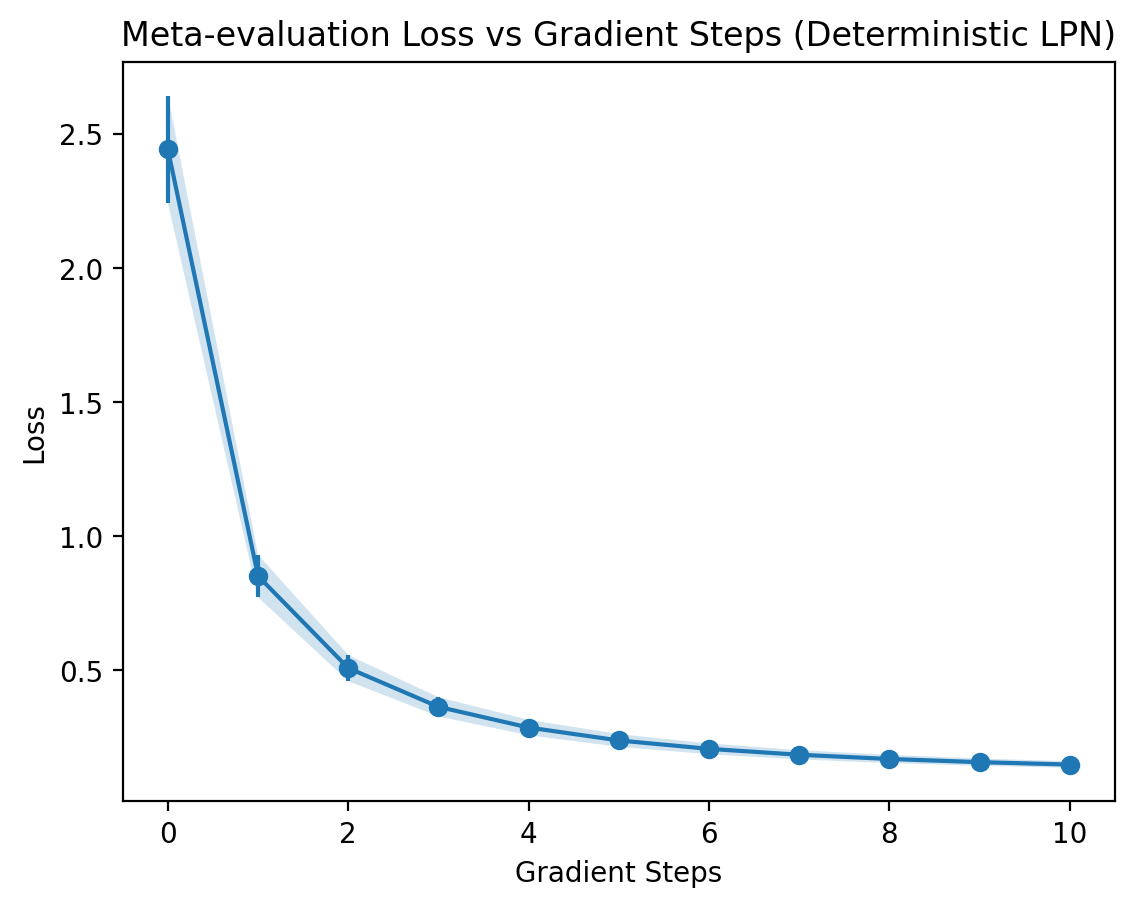

In [40]:
metaeval_losses, metaeval_mu, metaeval_ci = evaluate_deterministic_lpn(lpn, device)




In [41]:
num_parameters = sum(p.numel() for p in lpn.parameters())

In [42]:
eval_df = pd.DataFrame({"mu": metaeval_mu, "ci": metaeval_ci, "num_parameters": num_parameters})

eval_df.to_csv("..//eval_data/LPN_eval_tuned5.csv")

torch.sum(mse).item()=14.8015718460083
torch.sum(mse).item()=3.3211774826049805
torch.sum(mse).item()=1.3877527713775635
torch.sum(mse).item()=0.9998406767845154
torch.sum(mse).item()=0.8599369525909424
torch.sum(mse).item()=0.7788230180740356
torch.sum(mse).item()=0.7205860614776611
torch.sum(mse).item()=0.6739903688430786
torch.sum(mse).item()=0.6350719928741455
torch.sum(mse).item()=0.6018365025520325
torch.sum(mse).item()=0.572842001914978
torch.sum(mse).item()=0.5473259091377258
torch.sum(mse).item()=0.5247506499290466
torch.sum(mse).item()=0.5048106908798218
torch.sum(mse).item()=0.48716628551483154
torch.sum(mse).item()=0.47157540917396545
torch.sum(mse).item()=0.45815548300743103
torch.sum(mse).item()=0.446470707654953
torch.sum(mse).item()=0.4360436499118805
torch.sum(mse).item()=0.4267084002494812
torch.sum(mse).item()=0.4183465540409088
torch.sum(mse).item()=0.4107816219329834
torch.sum(mse).item()=0.4039214551448822
torch.sum(mse).item()=0.3977174162864685
torch.sum(mse).it

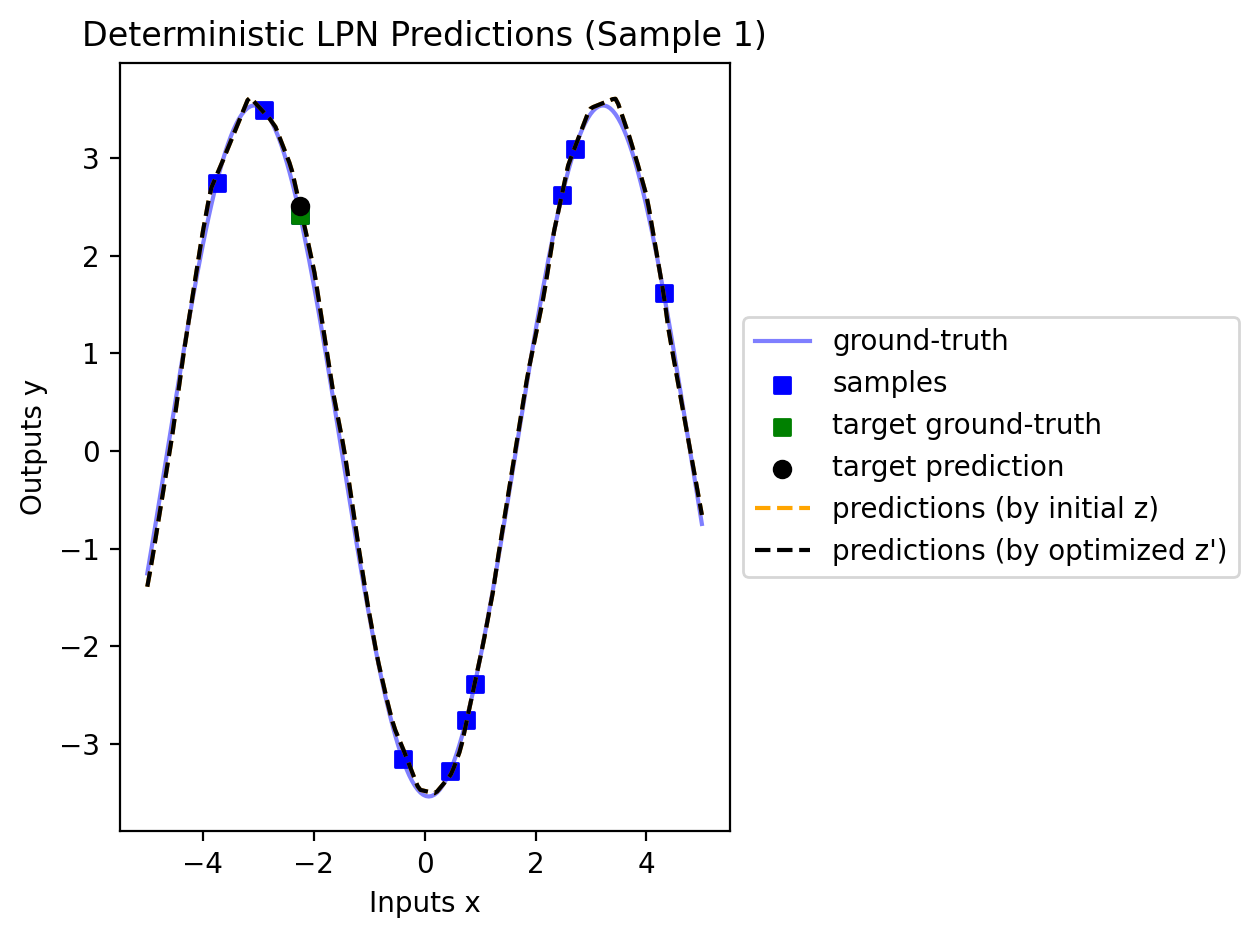

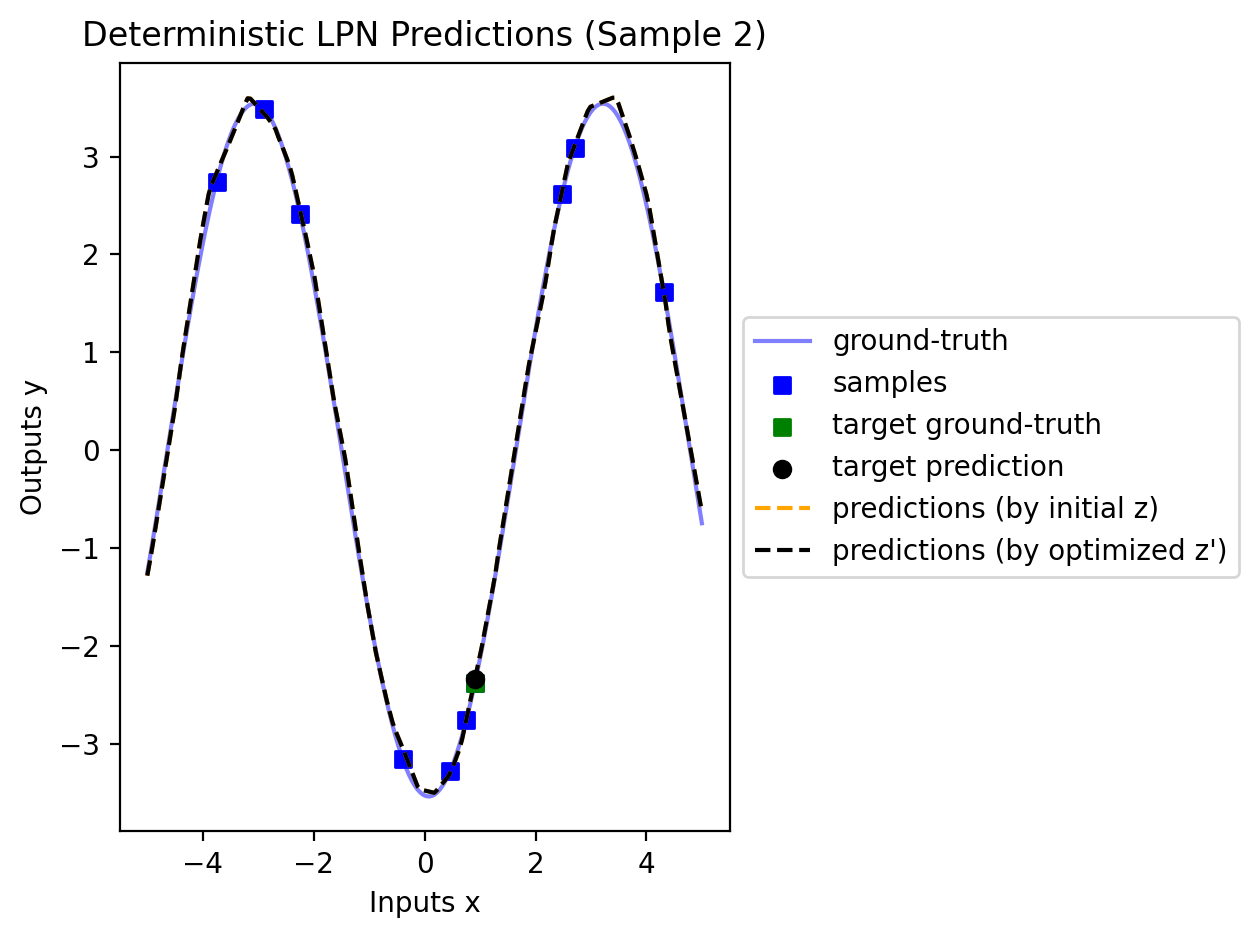

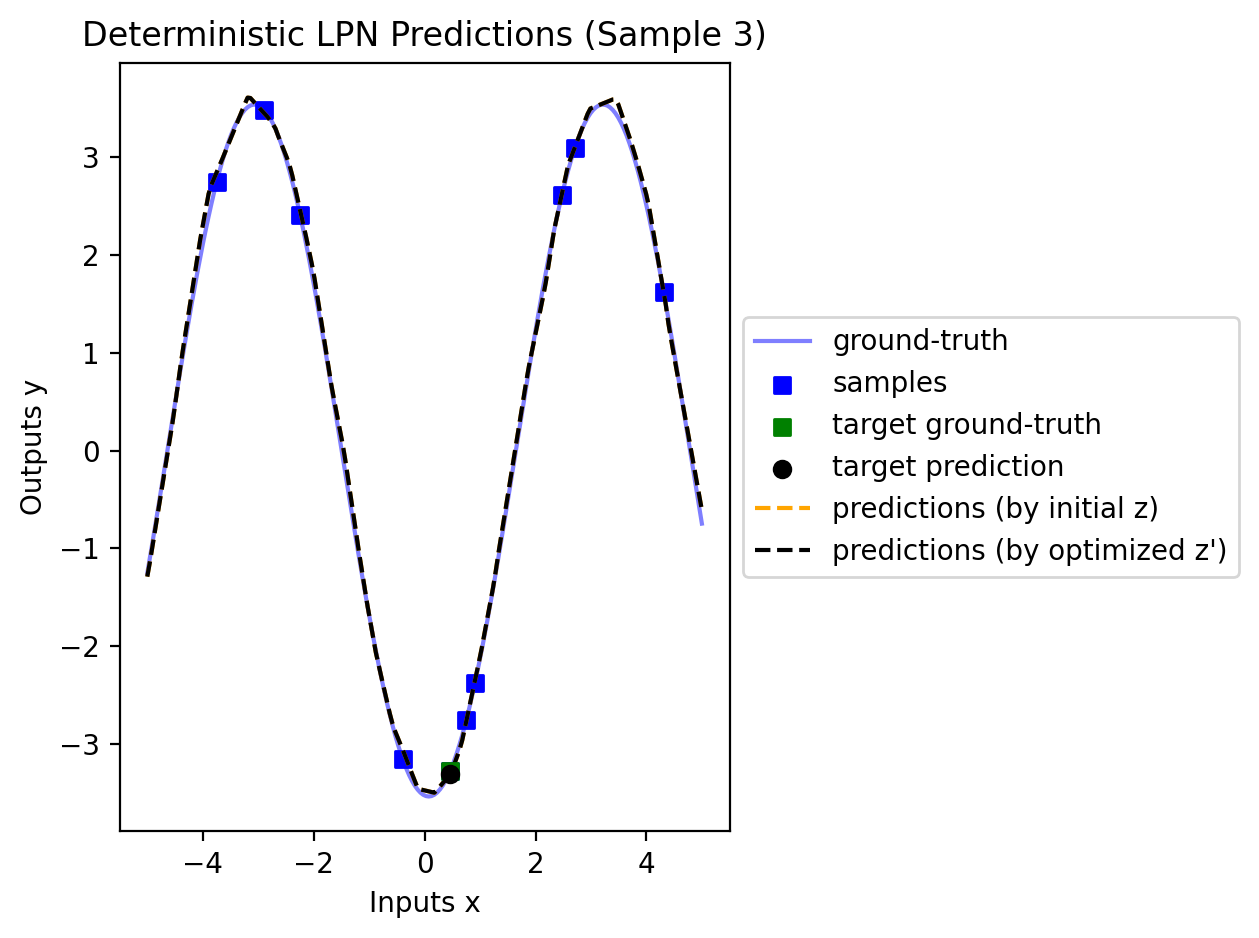

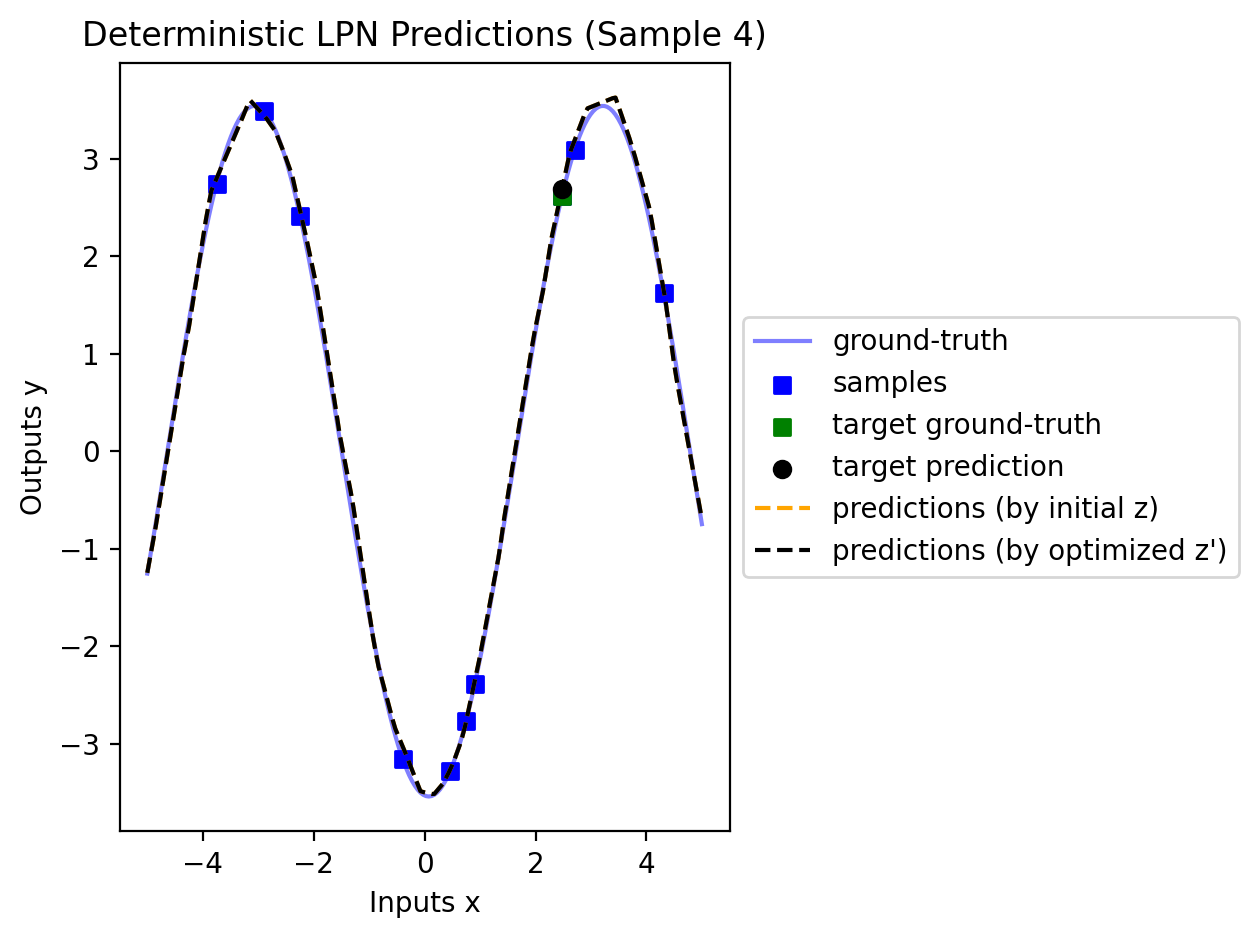

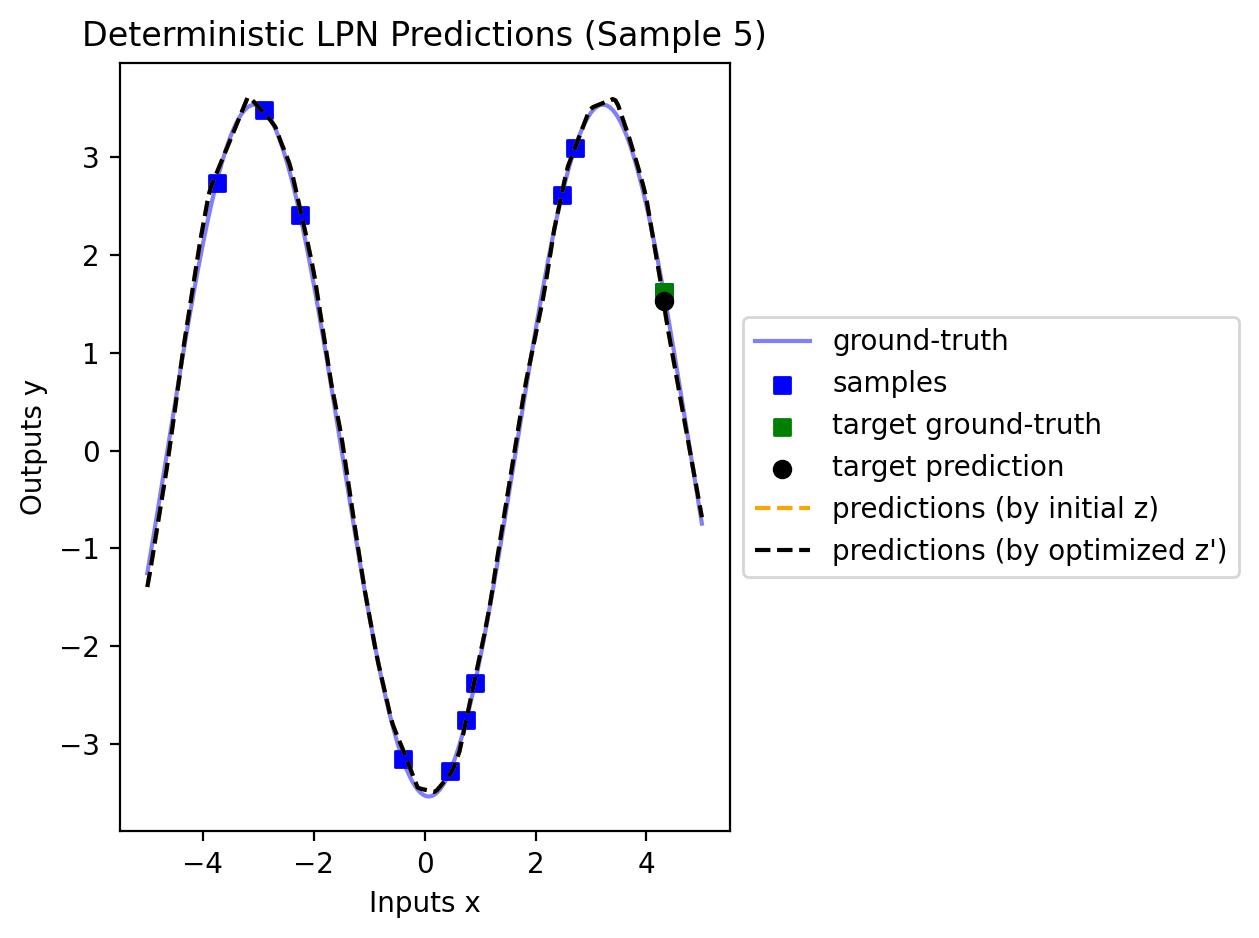

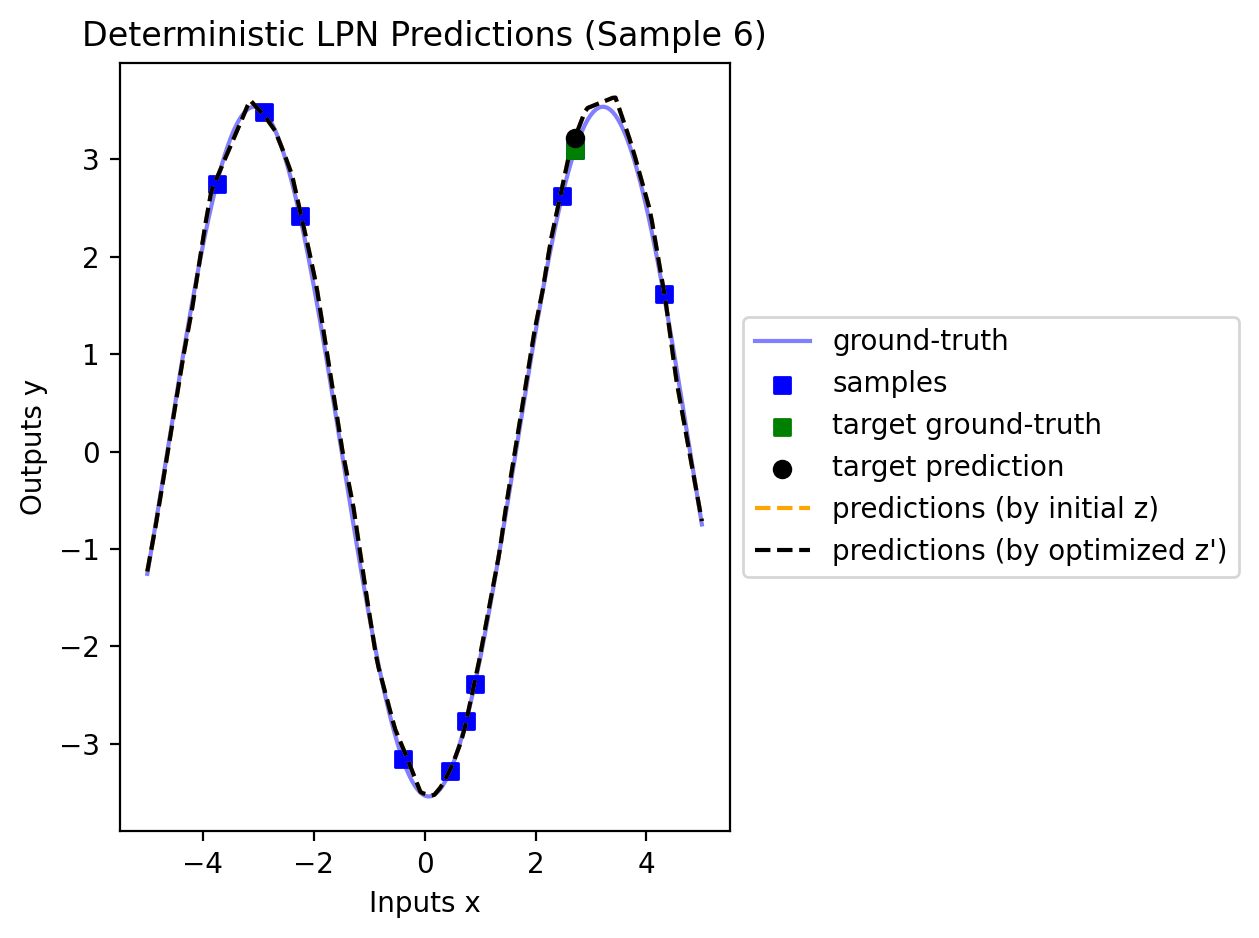

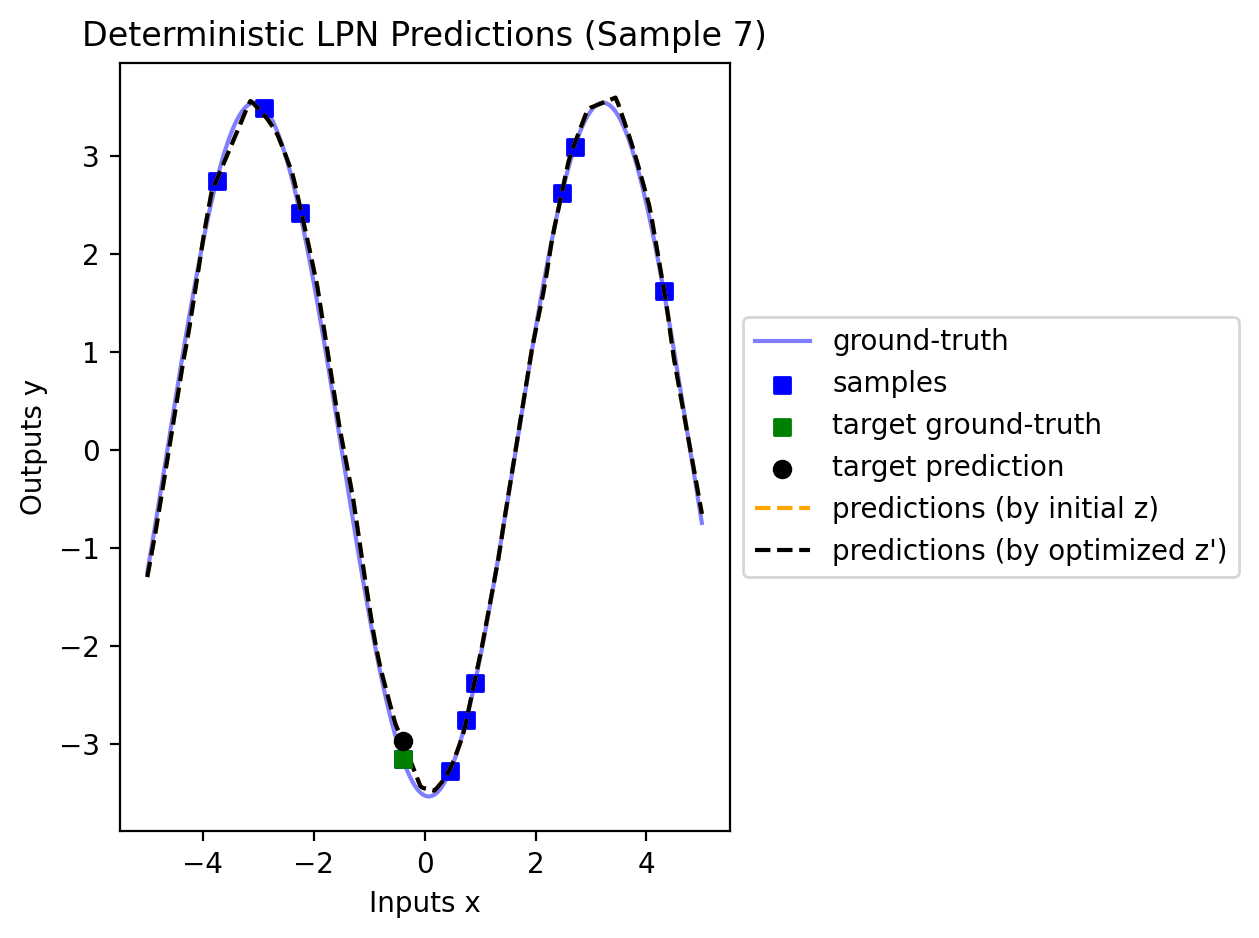

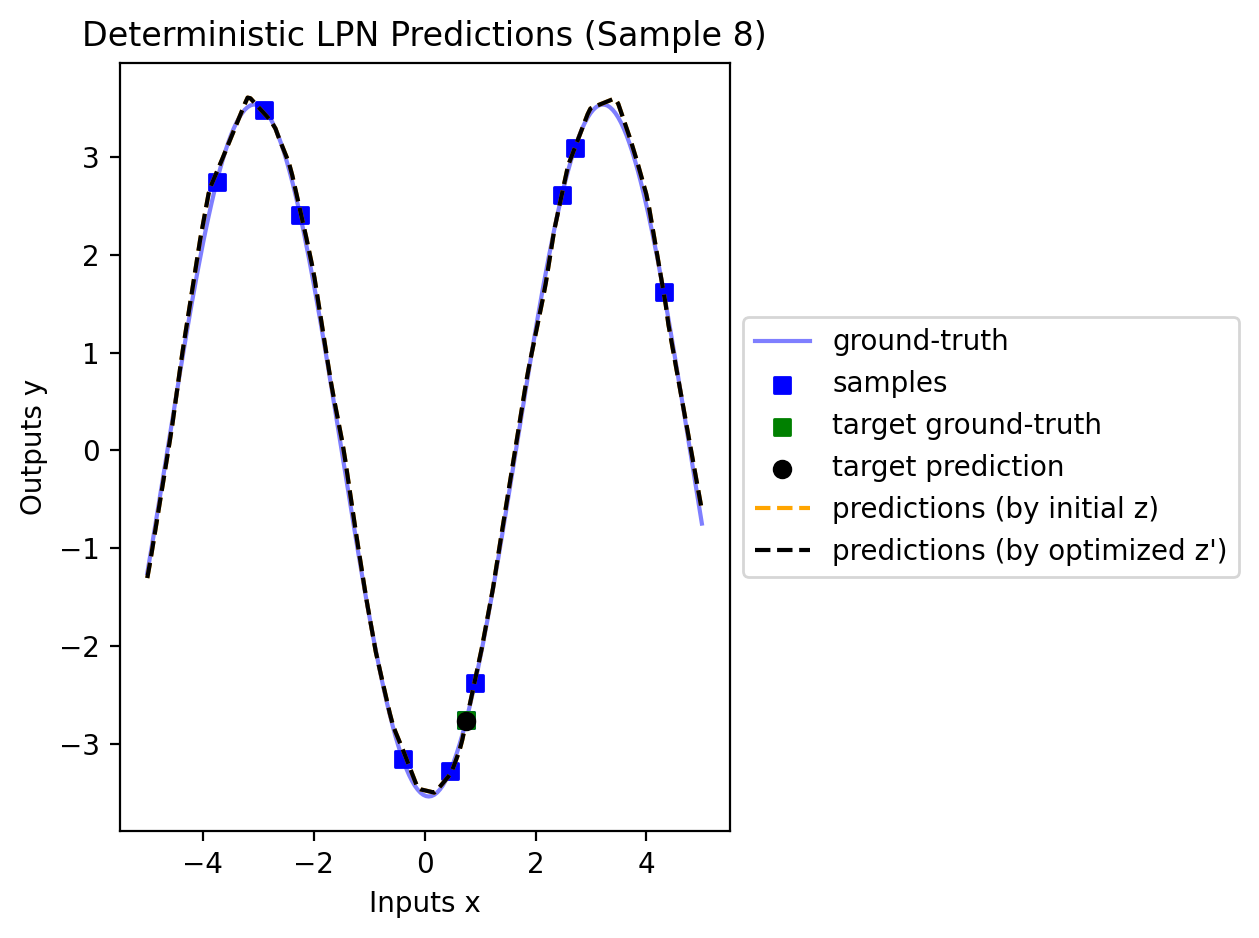

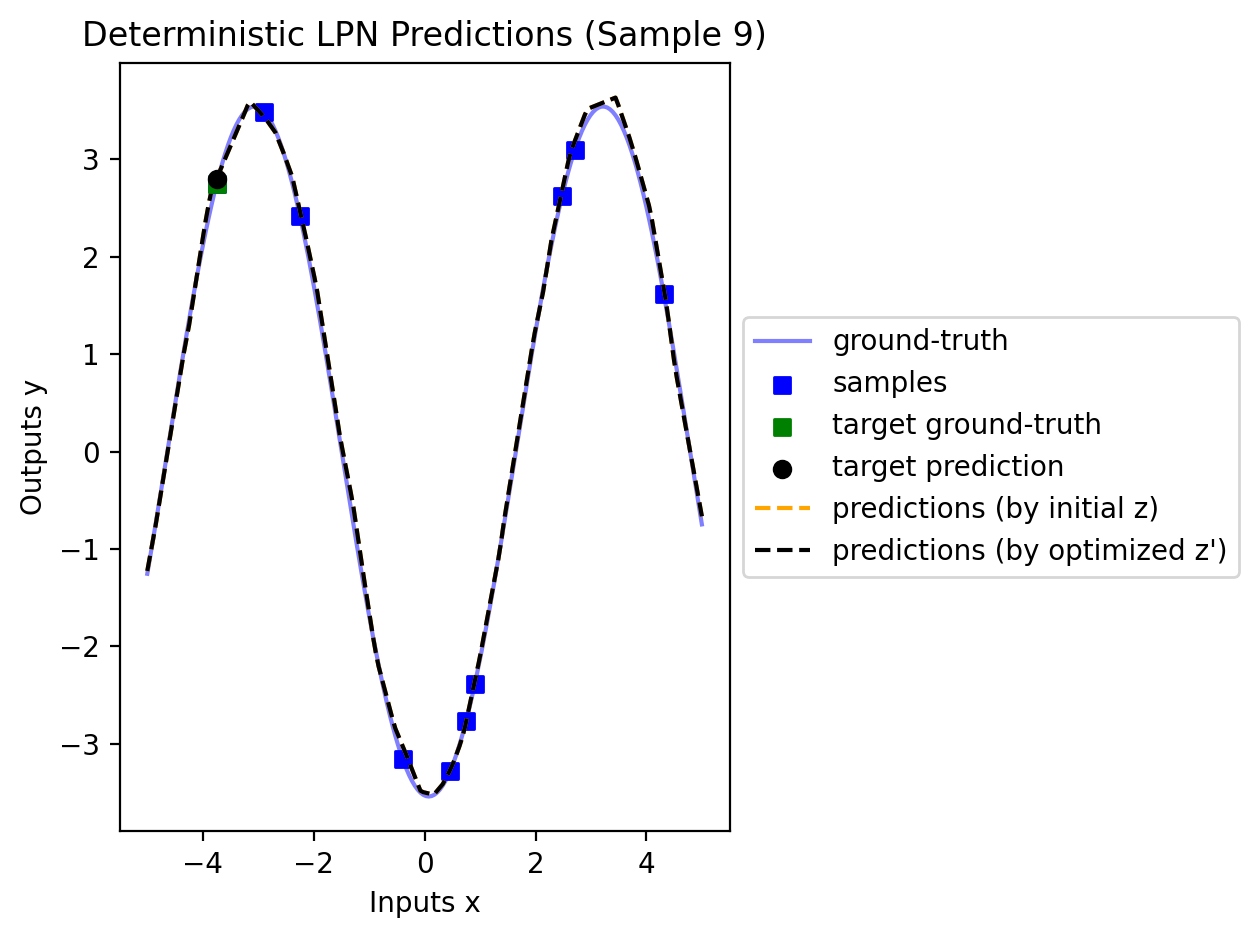

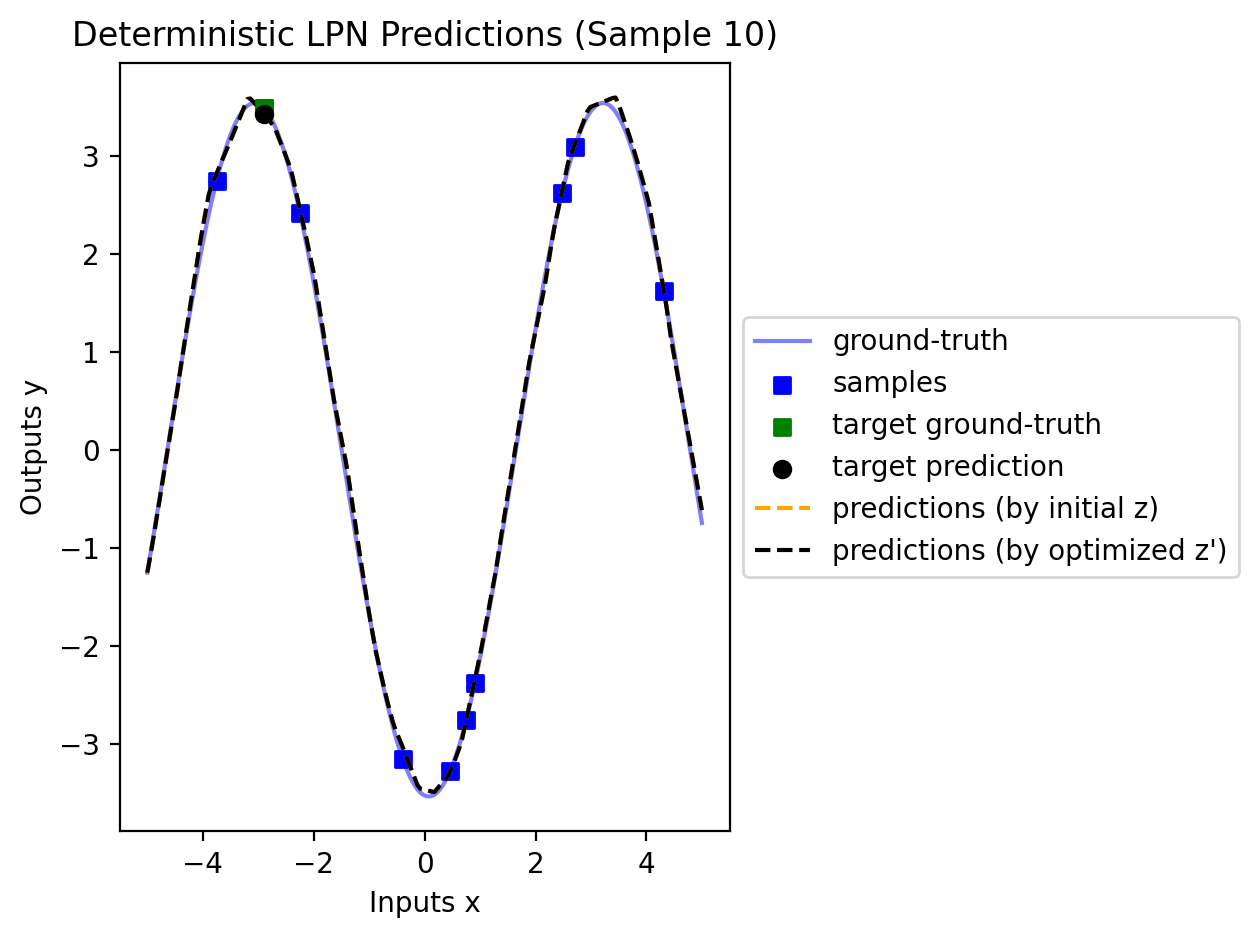

In [43]:
visualize_deterministic_lpn(lpn, device)